# Exercise 6: Train a ResNet & Squeeze and Exitation


In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import os
from PIL import Image
import ast
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy
import pickle


os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# Transforms for training and testing. We use the CIFAR 10 means
# and stdevs from https://github.com/facebookarchive/fb.resnet.torch/issues/180


train_transform = transforms.Compose([
        #transforms.RandomRotation(10),      # rotate +/- 10 degrees
        #transforms.RandomHorizontalFlip(),  # reverse 50% of images
        #transforms.Resize(224),             # resize shortest side to 224 pixels
        #transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.491, 0.482, 0.447],
                             [0.247, 0.243, 0.262])
    ])

test_transform = transforms.Compose([
        #transforms.Resize(224),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.491, 0.482, 0.447],
                             [0.247, 0.243, 0.262])
    ])


# Load the CIFAR-10 dataset

train_dataset = datasets.CIFAR10(root='./data', transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', transform=test_transform, train=False, download=True)

# Category labels

cat_labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

# Create data loaders from train/test datasets

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=128)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

dataloaders = {'train': train_dataloader, 'val': test_dataloader}

/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


Files already downloaded and verified
Files already downloaded and verified


In [2]:
class BasicBlock(nn.Module):
    '''
    BasicBlock: Simple residual block with two conv layers
    '''
    EXPANSION = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
class BottleneckBlock(nn.Module):
    '''
    BottleneckBlock: More powerful residual block with three convs, used for Resnet50 and up
    '''
    EXPANSION = 4
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.EXPANSION * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.EXPANSION * planes)

        self.shortcut = nn.Sequential()
        # If the output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != self.EXPANSION * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.EXPANSION * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
def ResNet18(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with two sets of two convolutions each: 2*2 + 2*2 + 2*2 + 2*2 = 16 conv layers
    last FC layer: 1
    Total layers: 1+16+1 = 18
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def ResNet34(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of two convolutions each: 3*2 + 4*2 + 6*2 + 3*2 = 32
    last FC layer: 1
    Total layers: 1+32+1 = 34
    '''
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of three convolutions each: 3*3 + 4*3 + 6*3 + 3*3 = 48
    last FC layer: 1
    Total layers: 1+48+1 = 50
    '''
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)


def ResNet101(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 23, 3] sets of three convolutions each: 3*3 + 4*3 + 23*3 + 3*3 = 99
    last FC layer: 1
    Total layers: 1+99+1 = 101
    '''
    return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)


def ResNet152(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 8, 36, 3] sets of three convolutions each: 3*3 + 8*3 + 36*3 + 3*3 = 150
    last FC layer: 1
    Total layers: 1+150+1 = 152
    '''
    return ResNet(BottleneckBlock, [3, 8, 36, 3], num_classes)

def top1_error(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels.data)
    return 1 - correct / len(labels)

### Training

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    since = time.time()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    train_errors = []
    val_errors = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_error = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_error += top1_error(outputs, labels) * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            epoch_error = running_error / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                train_errors.append(epoch_error)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                val_errors.append(epoch_error)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, weights_name)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, train_errors, val_loss_history, val_acc_history, val_errors




### Restnet

In [5]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
num_epochs= 25

# Create the model
resnet = ResNet34().to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
params_to_update = resnet.parameters()

#optimizer = optim.Adam(params_to_update, lr=0.01)
optimizer = torch.optim.SGD(params_to_update, lr=0.01, momentum=0.9, weight_decay=0.0005)


# Train the model
best_model, train_loss_history, train_acc_history, train_errors, val_loss_history, val_acc_history, val_errors = train_model(
        resnet, dataloaders, criterion, optimizer, num_epochs, 'resnet34_bestsofar')

# Save training statistics to a pickle file
with open('resnet_main_data.pkl', 'wb') as f:
    pickle.dump({'best_model': best_model, 'train_loss_history': train_loss_history,
                                           'train_acc_history': train_acc_history,
                                           'val_acc_history': val_acc_history,
                                           'val_loss_history': val_loss_history}, f)


Epoch 1/25
----------
train Loss: 1.4260 Acc: 0.4803
val Loss: 1.1482 Acc: 0.5886

Epoch 2/25
----------
train Loss: 0.8408 Acc: 0.7051
val Loss: 1.2570 Acc: 0.6046

Epoch 3/25
----------
train Loss: 0.5821 Acc: 0.7982
val Loss: 0.8390 Acc: 0.7264

Epoch 4/25
----------
train Loss: 0.4388 Acc: 0.8460
val Loss: 0.6997 Acc: 0.7763

Epoch 5/25
----------
train Loss: 0.3278 Acc: 0.8861
val Loss: 0.6593 Acc: 0.7889

Epoch 6/25
----------
train Loss: 0.2475 Acc: 0.9131
val Loss: 0.8064 Acc: 0.7668

Epoch 7/25
----------
train Loss: 0.1757 Acc: 0.9377
val Loss: 0.7582 Acc: 0.7791

Epoch 8/25
----------
train Loss: 0.1417 Acc: 0.9500
val Loss: 0.7280 Acc: 0.8054

Epoch 9/25
----------
train Loss: 0.1110 Acc: 0.9604
val Loss: 0.7027 Acc: 0.8163

Epoch 10/25
----------
train Loss: 0.0882 Acc: 0.9696
val Loss: 0.8073 Acc: 0.8107

Epoch 11/25
----------
train Loss: 0.0763 Acc: 0.9732
val Loss: 0.8776 Acc: 0.7980

Epoch 12/25
----------
train Loss: 0.0616 Acc: 0.9786
val Loss: 0.7759 Acc: 0.8223

E

### Visualize Loss & Accuracy of Train & Test dataset

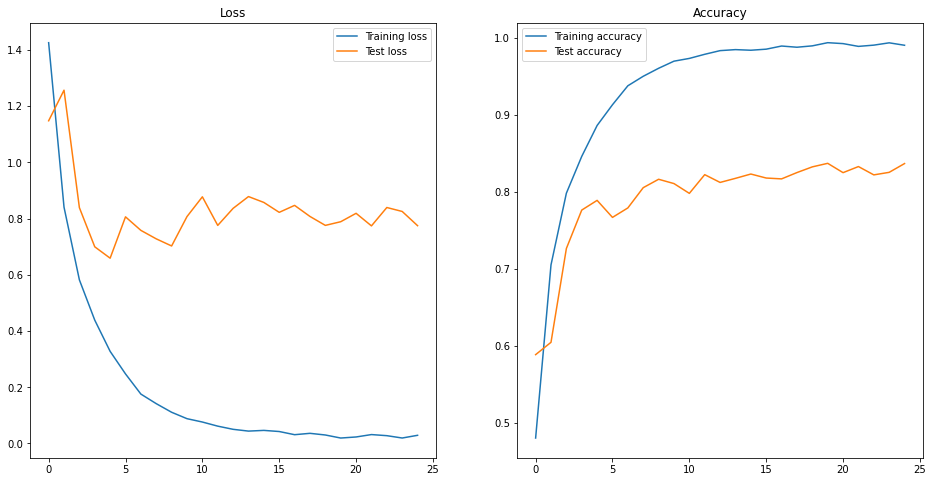

In [6]:
def Visualize_train_loss(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    fig = plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Training loss')
    plt.plot(val_loss_history, label='Test loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot([x.cpu() for x in train_acc_history], label='Training accuracy')
    plt.plot([x.cpu() for x in val_acc_history], label='Test accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show
    
Visualize_train_loss(train_loss_history, val_loss_history, train_acc_history, val_acc_history)


### Display some images in Testset with actual & predicted labels

In [7]:
# # Get ImageNet class labels
# import ast
# with open('imagenet1000_clsidx_to_labels.txt') as f:
#     label_data = f.read()
# class_labels = ast.literal_eval(label_data)

# # Select a random image from the dataset
# import numpy as np
# idx = np.arange(len(test_dataset))
# np.random.shuffle(idx)
# for x in range(5):
#     inputs, label = test_dataset[idx[x]]
#     output = model(inputs.to(device).unsqueeze(0) )
#     _, predicted_label = torch.max(output.data, 1)
#     plt.imshow(np.transpose(inputs.numpy(), (1, 2, 0)))
#     plt.title(f"Label: {class_labels[label]}, Predicted label: {class_labels[predicted_label.item()]}")
#     plt.axis('off')
#     plt.show()

In [8]:
# 'https://github.com/dsai-asia/RTML/blob/main/Labs/03-ResNet-SqueezeAndExcitation/03-ResNet-SqueezeAndExcitation.ipynb

### Squeeze and Excite networks

In [9]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
class ResidualSEBasicBlock(nn.Module):
    '''
    ResidualSEBasicBlock: Standard two-convolution residual block with an SE Module between the
                          second convolution and the identity addition
    '''
    EXPANSION = 1

    def __init__(self, in_planes, out_planes, stride=1, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.se = SELayer(out_planes, reduction)

        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with a 1x1 conv
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)              # se net add here
        out += self.shortcut(x)         # shortcut just plus it!!!
        out = F.relu(out)
        return out


def ResSENet18(num_classes = 10):
    return ResNet(ResidualSEBasicBlock, [2, 2, 2, 2], num_classes)
def ResSENet34(num_classes = 10):
    return ResNet(ResidualSEBasicBlock, [3, 4, 6, 3], num_classes)

In [13]:
ressenet = ResSENet34().to(device)
# Optimizer, loss function
criterion2 = nn.CrossEntropyLoss()
params_to_update2 = ressenet.parameters()
# optimizer2 = optim.Adam(params_to_update2, lr=0.01)
optimizer2 = torch.optim.SGD(params_to_update2, lr=0.01, momentum=0.9, weight_decay=0.0005)
best_model, train_loss_history, train_acc_history, train_errors, val_loss_history, val_acc_history, val_errors 

se_best_model, se_train_loss_history, se_train_acc_history, se_train_errors, se_val_loss_history, se_val_acc_history, se_val_errors  = train_model(ressenet, dataloaders, criterion2, optimizer2, num_epochs, 'ressenet34_bestsofar')

Epoch 1/25
----------
train Loss: 1.2787 Acc: 0.5347
val Loss: 1.3947 Acc: 0.5429

Epoch 2/25
----------
train Loss: 0.7393 Acc: 0.7386
val Loss: 0.7022 Acc: 0.7563

Epoch 3/25
----------
train Loss: 0.5158 Acc: 0.8205
val Loss: 0.7634 Acc: 0.7488

Epoch 4/25
----------
train Loss: 0.3769 Acc: 0.8674
val Loss: 0.8721 Acc: 0.7358

Epoch 5/25
----------
train Loss: 0.2607 Acc: 0.9089
val Loss: 0.7596 Acc: 0.7741

Epoch 6/25
----------
train Loss: 0.1897 Acc: 0.9335
val Loss: 0.7997 Acc: 0.7720

Epoch 7/25
----------
train Loss: 0.1369 Acc: 0.9525
val Loss: 0.8496 Acc: 0.7856

Epoch 8/25
----------
train Loss: 0.1051 Acc: 0.9632
val Loss: 0.7744 Acc: 0.8025

Epoch 9/25
----------
train Loss: 0.0705 Acc: 0.9765
val Loss: 0.9126 Acc: 0.7873

Epoch 10/25
----------
train Loss: 0.0572 Acc: 0.9810
val Loss: 0.7475 Acc: 0.8137

Epoch 11/25
----------
train Loss: 0.0516 Acc: 0.9818
val Loss: 0.7751 Acc: 0.8122

Epoch 12/25
----------
train Loss: 0.0432 Acc: 0.9860
val Loss: 0.8435 Acc: 0.8030

E

<function matplotlib.pyplot.show(close=None, block=None)>

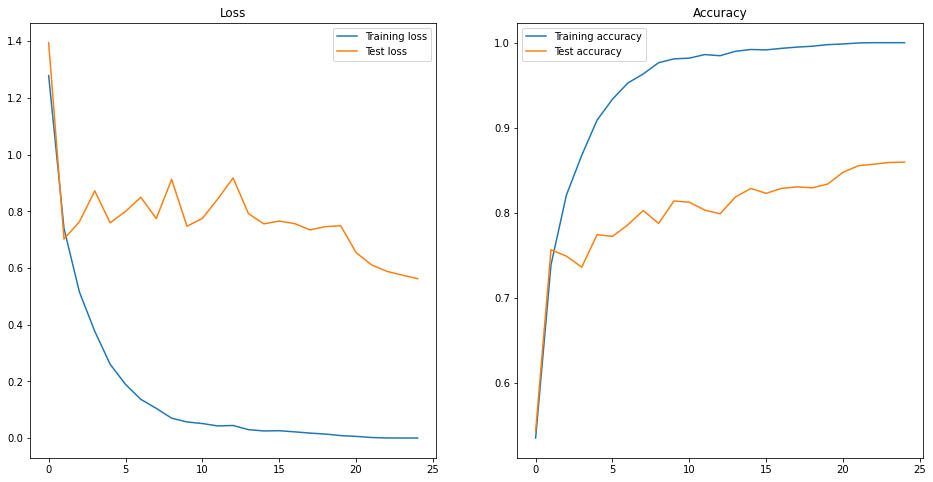

In [14]:
# import matplotlib.pyplot as plt

# def plot_data(train_loss_history, val_acc_history, train_loss_history2, val_acc_history2):
#     plt.plot(train_loss_history, label = 'ResNet34')
#     plt.plot(train_loss_history2, label = 'ResSENet34')
#     plt.title('Training loss over time')
#     plt.legend()
#     plt.show()
#     plt.plot([x.cpu() for x in val_acc_history], label = 'ResNet34')
#     plt.plot([x.cpu() for x in val_acc_history2], label = 'ResSENet34')
#     plt.title('Validation accuracy over time')
#     plt.legend()
#     plt.show()
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(se_train_loss_history, label='Training loss')
plt.plot(se_val_loss_history, label='Test loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in se_train_acc_history], label='Training accuracy')
plt.plot([x.cpu() for x in se_val_acc_history], label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show


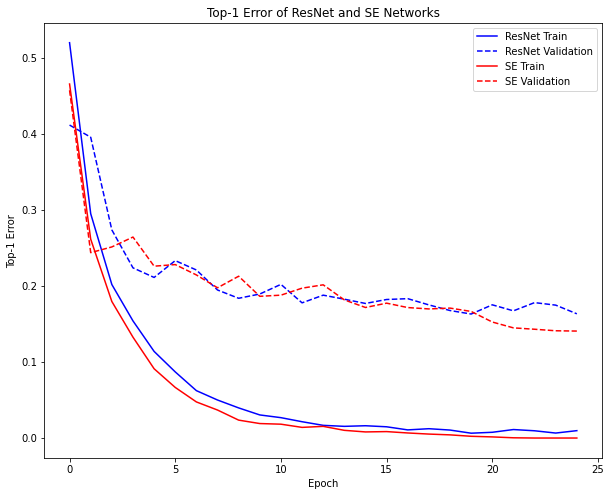

In [15]:
epochs = range(num_epochs)
fig = plt.figure(figsize=(10, 8))
plt.plot(epochs, [x.cpu() for x in train_errors], 'b-', label='ResNet Train')
plt.plot(epochs, [x.cpu() for x in val_errors], 'b--', label='ResNet Validation')
plt.plot(epochs, [x.cpu() for x in se_train_errors], 'r-', label='SE Train')
plt.plot(epochs, [x.cpu() for x in se_val_errors], 'r--', label='SE Validation')
plt.title('Top-1 Error of ResNet and SE Networks')
plt.xlabel('Epoch')
plt.ylabel('Top-1 Error')
plt.legend()
plt.show()
